In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read data

In [2]:
def read_data(path, index_col=0):
    df = pd.read_csv(path, index_col=index_col)
    return df

In [3]:
train_path = "train.csv"
test_path = "test.csv"

train, test = read_data(train_path), read_data(test_path)

print(len(train), len(test))

87 59


In [4]:
train.head()

,MO HLADR+ MFI (cells/ul),Neu CD64+MFI (cells/ul),CD3+T (cells/ul),CD8+T (cells/ul),CD4+T (cells/ul),NK (cells/ul),CD19+ (cells/ul),CD45+ (cells/ul),Age,Sex 0M1F,Mono CD64+MFI (cells/ul),label
id,,,,,,,,,,,,
0,3556.0,2489.0,265.19,77.53,176.55,0.00,4.20,307.91,52,0,7515.0,1
1,1906.0,134.0,1442.61,551.90,876.07,112.10,168.15,1735.48,20,1,1756.0,0
2,1586.0,71.0,1332.74,684.20,655.26,244.95,216.52,1820.04,28,1,1311.0,0
3,683.0,94.0,419.23,255.80,162.17,72.05,44.68,538.22,55,1,1443.0,0
4,1032.0,71.0,1102.72,480.27,625.30,188.78,130.77,1427.97,28,1,1542.0,0


## EDA
- check missing value

In [5]:
train.isnull().sum()

MO HLADR+ MFI (cells/ul)    1
Neu CD64+MFI (cells/ul)     1
CD3+T (cells/ul)            0
CD8+T (cells/ul)            0
CD4+T (cells/ul)            0
NK (cells/ul)               0
CD19+ (cells/ul)            0
CD45+ (cells/ul)            0
Age                         0
Sex 0M1F                    0
Mono CD64+MFI (cells/ul)    1
label                       0
dtype: int64

In [6]:
test.isnull().sum()

MO HLADR+ MFI (cells/ul)    0
Neu CD64+MFI (cells/ul)     0
CD3+T (cells/ul)            0
CD8+T (cells/ul)            0
CD4+T (cells/ul)            0
NK (cells/ul)               0
CD19+ (cells/ul)            0
CD45+ (cells/ul)            0
Age                         0
Sex 0M1F                    0
Mono CD64+MFI (cells/ul)    0
dtype: int64

In [7]:
train[train["MO HLADR+ MFI (cells/ul)"].isnull()]

,MO HLADR+ MFI (cells/ul),Neu CD64+MFI (cells/ul),CD3+T (cells/ul),CD8+T (cells/ul),CD4+T (cells/ul),NK (cells/ul),CD19+ (cells/ul),CD45+ (cells/ul),Age,Sex 0M1F,Mono CD64+MFI (cells/ul),label
id,,,,,,,,,,,,
39,NaN,NaN,1336.54,739.71,550.3,68.46,192.07,1615.68,21,0,NaN,0


In [8]:
def plot_histogram(df, col_name, title="", bins=20, transform=None):
    if transform == 'log':
        plt.hist(np.where(df[col] != 0, np.log(df[col]), 0), bins=bins)
    else:
        plt.hist(df[col], bins=bins)
    if title:
        plt.title("Histogram of %s" % (col + title))
    else:
        plt.title("Histogram of %s" % col)
    plt.show()

In [30]:
num_col = [col for col in train.columns if col not in ["Sex 0M1F", "label"]]
cat_col = ["Sex 0M1F"]
label_col = ["label"]

- plot histogram distribution before and after log transformation
    - all numeric columns are right skewed, except for age (with two peaks)

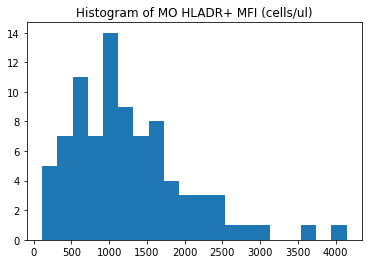

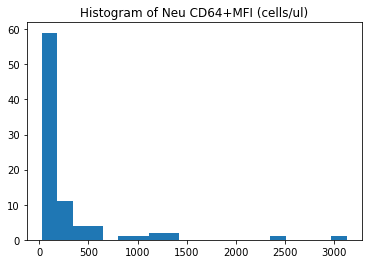

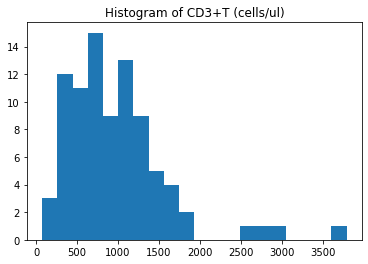

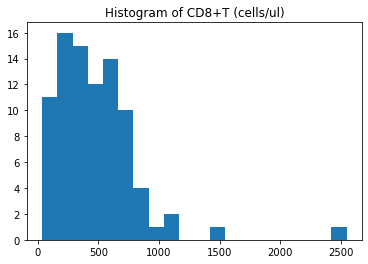

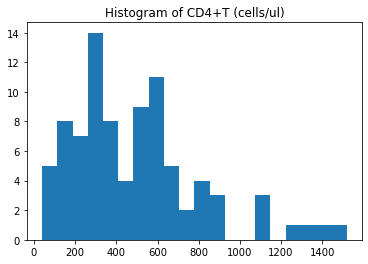

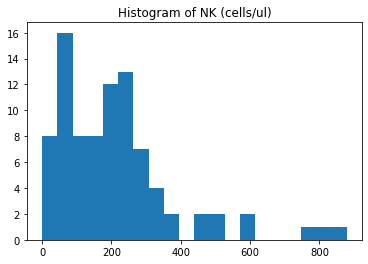

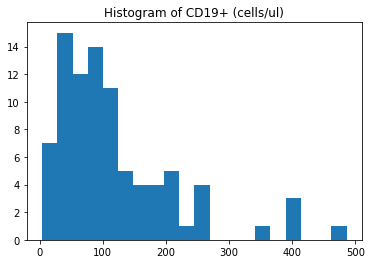

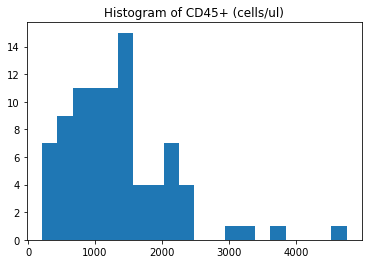

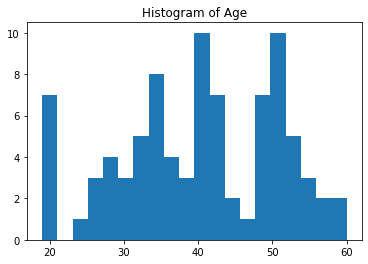

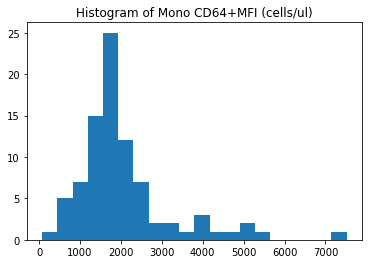

In [10]:
for col in num_col:
    plot_histogram(train, col)

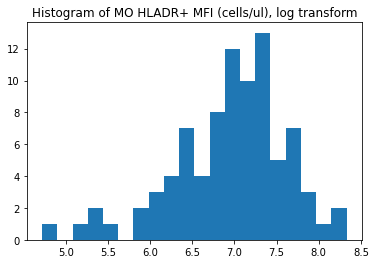

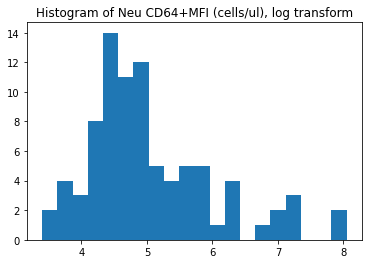

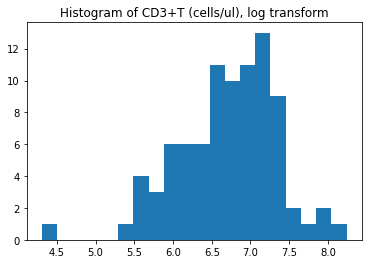

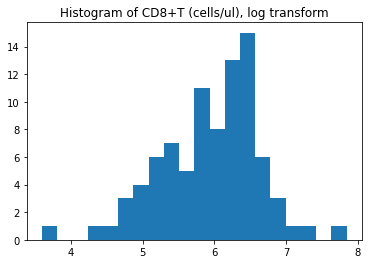

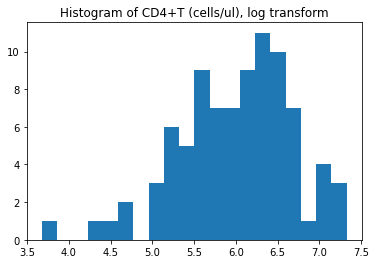

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


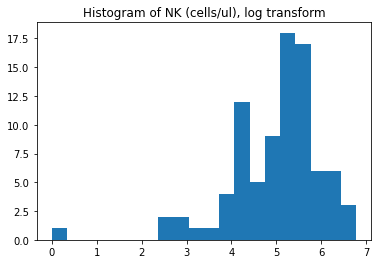

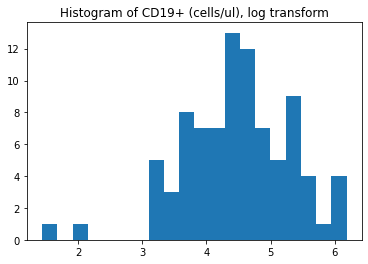

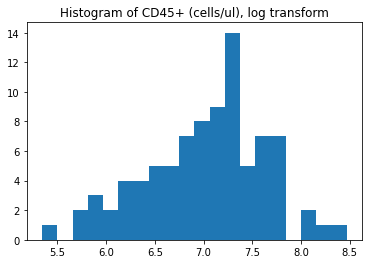

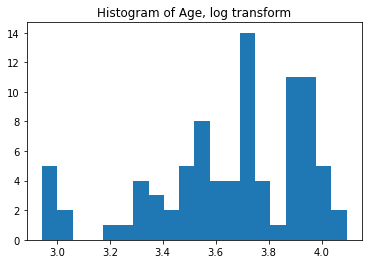

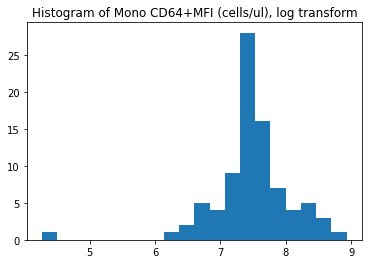

In [11]:
for col in num_col:
    plot_histogram(train, col, title=", log transform", bins=20, transform='log')

- check class distribution: quite balanced

In [35]:
train["label"].value_counts()

0    58
1    29
Name: label, dtype: int64

- use median to fill missing value

In [13]:
for col in ["MO HLADR+ MFI (cells/ul)", "Neu CD64+MFI (cells/ul)", "Mono CD64+MFI (cells/ul)"]:
    print(col)
    print("\tmedian: ", train[col].median())
    print("\tmean: ", train[col].mean())

MO HLADR+ MFI (cells/ul)
	median:  1108.5
	mean:  1264.2441860465117
Neu CD64+MFI (cells/ul)
	median:  124.5
	mean:  290.3837209302326
Mono CD64+MFI (cells/ul)
	median:  1757.5
	mean:  2066.5348837209303


In [14]:
for col in ["MO HLADR+ MFI (cells/ul)", "Neu CD64+MFI (cells/ul)", "Mono CD64+MFI (cells/ul)"]:
    train[col] = train[col].fillna(train[col].median())

- check correlation with label
    - except for age and sex, the other features have quite strong correlation
    - many features are quite strongly correlated

In [26]:
cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "10pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '10pt')])
]

corr = train.corr()
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '50px', 'font-size': '10pt'})\
    .set_caption("Correlation matrix of raw feature data")\
    .set_precision(2)\
    .set_table_styles(magnify())

,MO HLADR+ MFI (cells/ul),Neu CD64+MFI (cells/ul),CD3+T (cells/ul),CD8+T (cells/ul),CD4+T (cells/ul),NK (cells/ul),CD19+ (cells/ul),CD45+ (cells/ul),Age,Sex 0M1F,Mono CD64+MFI (cells/ul),label
MO HLADR+ MFI (cells/ul),1.00,0.14,0.12,0.01,0.20,0.11,0.15,0.13,0.12,-0.01,0.32,-0.28
Neu CD64+MFI (cells/ul),0.14,1.00,-0.25,-0.24,-0.23,-0.31,-0.25,-0.30,0.08,0.07,0.69,0.54
CD3+T (cells/ul),0.12,-0.25,1.00,0.92,0.91,0.49,0.68,0.98,-0.42,0.17,-0.30,-0.42
CD8+T (cells/ul),0.01,-0.24,0.92,1.00,0.69,0.44,0.57,0.89,-0.39,0.19,-0.29,-0.38
CD4+T (cells/ul),0.20,-0.23,0.91,0.69,1.00,0.49,0.68,0.90,-0.35,0.12,-0.26,-0.38
NK (cells/ul),0.11,-0.31,0.49,0.44,0.49,1.00,0.36,0.65,0.12,-0.12,-0.29,-0.47
CD19+ (cells/ul),0.15,-0.25,0.68,0.57,0.68,0.36,1.00,0.74,-0.35,0.15,-0.33,-0.37
CD45+ (cells/ul),0.13,-0.30,0.98,0.89,0.90,0.65,0.74,1.00,-0.35,0.12,-0.34,-0.48
Age,0.12,0.08,-0.42,-0.39,-0.35,0.12,-0.35,-0.35,1.00,-0.18,0.12,0.04
Sex 0M1F,-0.01,0.07,0.17,0.19,0.12,-0.12,0.15,0.12,-0.18,1.00,-0.01,0.05


## Feature engineering
- apply log transformation to numertic features, except for age

In [27]:
def log_transform(df, col_list):
    for col in col_list:
        df[col] = np.where(df[col] !=0, np.log(df[col]), 0)
    return df

In [32]:
train = log_transform(train, [c for c in num_col if c != "Age"])
test = log_transform(test, [c for c in num_col if c != "Age"])

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


- convert age to bins: <30, 30-40, 40-50, >50, and apply one-hot

In [78]:
def discretize(x):
    if x < 30:
        return "<29"
    elif x >= 30 and x < 40:
        return "30-39"
    elif x >= 40 and x < 50:
        return "40-49"
    elif x >= 50:
        return ">50"

In [82]:
train["Age_group"] = train["Age"].apply(lambda x: discretize(x))
test["Age_group"] = test["Age"].apply(lambda x: discretize(x))

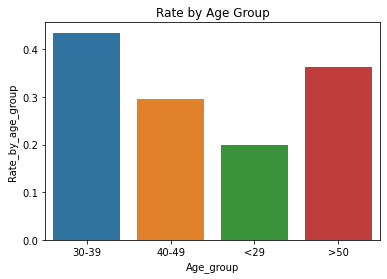

In [83]:
rate_by_age_group = train.groupby(by='Age_group').apply(
                        lambda x: x['label'].sum() / x['label'].count()
                    ).reset_index()

rate_by_age_group.columns = ["Age_group", "Rate_by_age_group"]

sns.barplot(x="Age_group", y="Rate_by_age_group", data=rate_by_age_group)
plt.title("Rate by Age Group")
plt.show()

In [85]:
train = pd.get_dummies(train).drop("Age", axis=1)
test = pd.get_dummies(test).drop("Age", axis=1)

In [89]:
corr_1 = train.corr()
corr_1.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '50px', 'font-size': '10pt'})\
    .set_caption("Correlation matrix of transformed feature data")\
    .set_precision(2)\
    .set_table_styles(magnify())

,MO HLADR+ MFI (cells/ul),Neu CD64+MFI (cells/ul),CD3+T (cells/ul),CD8+T (cells/ul),CD4+T (cells/ul),NK (cells/ul),CD19+ (cells/ul),CD45+ (cells/ul),Sex 0M1F,Mono CD64+MFI (cells/ul),label,Age_group_30-39,Age_group_40-49,Age_group_<29,Age_group_>50
MO HLADR+ MFI (cells/ul),1.00,-0.12,0.20,0.10,0.26,0.16,0.09,0.21,-0.08,0.33,-0.35,-0.10,-0.14,-0.03,0.27
Neu CD64+MFI (cells/ul),-0.12,1.00,-0.46,-0.46,-0.39,-0.56,-0.43,-0.51,0.08,0.54,0.73,0.11,-0.09,-0.04,0.03
CD3+T (cells/ul),0.20,-0.46,1.00,0.92,0.92,0.61,0.57,0.97,0.06,-0.33,-0.51,0.10,-0.17,0.27,-0.15
CD8+T (cells/ul),0.10,-0.46,0.92,1.00,0.74,0.60,0.51,0.90,0.10,-0.36,-0.49,0.03,-0.05,0.27,-0.21
CD4+T (cells/ul),0.26,-0.39,0.92,0.74,1.00,0.56,0.54,0.90,-0.00,-0.24,-0.44,0.11,-0.27,0.25,-0.04
NK (cells/ul),0.16,-0.56,0.61,0.60,0.56,1.00,0.54,0.74,-0.05,-0.29,-0.59,0.01,-0.09,0.07,0.01
CD19+ (cells/ul),0.09,-0.43,0.57,0.51,0.54,0.54,1.00,0.67,0.16,-0.41,-0.44,0.06,-0.11,0.33,-0.23
CD45+ (cells/ul),0.21,-0.51,0.97,0.90,0.90,0.74,0.67,1.00,0.04,-0.36,-0.57,0.08,-0.18,0.27,-0.12
Sex 0M1F,-0.08,0.08,0.06,0.10,-0.00,-0.05,0.16,0.04,1.00,-0.01,0.05,-0.16,0.05,0.29,-0.14
Mono CD64+MFI (cells/ul),0.33,0.54,-0.33,-0.36,-0.24,-0.29,-0.41,-0.36,-0.01,1.00,0.28,0.04,-0.06,-0.13,0.14


## Export data

In [92]:
if not os.path.exists("data"):
    os.mkdir("data")
    
train.to_csv("data/train.csv", index=False)
test.to_csv("data/test.csv", index=False)